In [80]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense
from keras.models import Sequential, load_model
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Run this command to import the DataFrame from the other notebook
%store -r combinedInRangeDf

# Load the combined dataframe
#data = pd.read_csv(r'/Users/aaroncao/Documents/California Wildfire Project/combinedInRangeDf.csv')
x = combinedInRangeDf.copy()
print(x.head())

       STATION      AWND  AVG PRECIP  TOTAL PRECIP   AVG SNOW  TOTAL SNOW  \
0  USC00045091  5.363065    0.071429          0.50   0.540722    3.785052   
1  USC00045091  5.363065    0.240000          1.20   8.000000   16.000000   
2  USC00045091  5.363065    0.497143          3.48  13.200000   39.600000   
3  USC00045091  5.363065    0.741429          5.19  11.000000   33.000000   
4  USC00045091  5.309970    0.077143          0.54   0.800000    4.000000   

    AVG TEMP  AVG MAX TEMP  MAX TEMP  AVG MIN TEMP  MIN TEMP      TAVG2  \
0  47.376344     41.714286      50.0     27.142857      16.0  34.428571   
1  47.376344     42.857143      53.0     31.285714      22.0  37.071429   
2  47.376344     35.333333      46.0     11.166667       5.0  23.250000   
3  47.376344     34.857143      40.0      9.285714      -2.0  22.071429   
4  49.581029     53.142857      56.0     24.428571      18.0  38.785714   

   LATITUDE  LONGITUDE  ELEVATION       Begin         End  fire fire arr  
0  33.81299

In [82]:
data = x.copy()

data.loc[data['fire'] == 'None', 'occurrence'] = 0
data.loc[data['fire'] == 'minor', 'occurrence'] = 1
data.loc[data['fire'] == 'major', 'occurrence'] = 1
# Shift the target variable to get the target for the next week
data['fire next week'] = data.groupby('STATION')['occurrence'].shift(-1)
data['occurrence and severity'] = data.groupby('STATION')['fire'].shift(-1)
# Drop the last row with NaN target since there is no target for it
data = data.dropna()

# Define the size of the rolling window
#window_size = 7  # Number of previous weeks to consider
window_size = 20

features = ['AWND', 'AVG PRECIP', 'TOTAL PRECIP','AVG SNOW','TOTAL SNOW','AVG TEMP','AVG MAX TEMP','MAX TEMP','AVG MIN TEMP','MIN TEMP','LATITUDE','LONGITUDE','ELEVATION', 'occurrence']
target = ['fire next week', 'occurrence and severity']

# Split data into features and target
#X = data[features]  # Features integrated later
#y = data[target]     # Target

# Apply rolling window to create sequences of inputs and targets
X_rolling = []
y_rolling_total = []

grouped_data = data.groupby('STATION')
for group_name, group_data in grouped_data:
    group_size = len(group_data)

    # Iterate within the current group
    for i in range(group_size - window_size + 1):

        X_rolling.append(group_data[features].iloc[i:i+window_size].values.flatten())
        y_rolling_total.append(group_data[target].iloc[i+window_size-1])

#for i in range(len(X) - window_size + 1):
#    X_rolling.append(X.iloc[i:i+window_size].values.flatten())
#    y_rolling.append(y.iloc[i+window_size-1])

# Convert to numpy arrays
X_rolling = pd.DataFrame(X_rolling)
y_rolling_total = pd.DataFrame(y_rolling_total)
print(y_rolling_total.value_counts())

# Split data into train and test sets
X_train, X_test, y_train_total, y_test_total = train_test_split(X_rolling, y_rolling_total, test_size=0.2, shuffle=True)
y_train = y_train_total.iloc[:, 0] #only get first column. second column is combined occurence and severity for use later
y_test = y_test_total.iloc[:, 0]

y_test_combined = y_test_total.iloc[:, 1] #***

# Create and train the Random Forest classifier
occurrence_model = RandomForestClassifier()
occurrence_model.fit(X_train, y_train)

fire next week  occurrence and severity
0.0             None                       7733
1.0             minor                       568
                major                        82
dtype: int64


RandomForestClassifier()

In [92]:

data['severity next week'] = data.groupby('STATION')['fire'].shift(-1)
# Drop the last row with NaN target since there is no target for it
data = data.dropna()

#print(data['severity next week'].value_counts())
# Apply rolling window to create sequences of inputs and targets

X_rolling_fire_only = []
y_rolling_fire_only = []

grouped_data = data.groupby('STATION')
for group_name, group_data in grouped_data:
    group_size = len(group_data)
    #print(group_data['severity next week'].value_counts())
    # Iterate within the current group
    for i in range(group_size - window_size + 1):
        if (group_data.iat[i+window_size-1, data.columns.get_loc('severity next week')]!='None'):

            #print(group_data.iat[i+window_size-1, data.columns.get_loc('severity next week')])
            #print(group_data['severity next week'].iloc[i+window_size-1])

            X_rolling_fire_only.append(group_data[features].iloc[i:i+window_size].values.flatten())
            y_rolling_fire_only.append(group_data['severity next week'].iloc[i+window_size-1])
            


X_rolling_fire_only = pd.DataFrame(X_rolling_fire_only)
y_rolling_fire_only = pd.Series(y_rolling_fire_only)
#print(data['fire'].value_counts())
#print(data['severity next week'].value_counts())
#print(y_rolling_fire_only.value_counts())

# Split data into train and test sets
test_size = 0.2
X_train_fire_only, X_test_fire_only, y_train_fire_only, y_test_fire_only = train_test_split(X_rolling_fire_only, y_rolling_fire_only, test_size=test_size, shuffle=True)

severity_model = RandomForestClassifier()  #MAYBE CHANGE TO A REGRESSOR TO PREDICT ACRES BURNED?
severity_model.fit(X_train_fire_only, y_train_fire_only)

# Evaluate the model on the test set



RandomForestClassifier()

Occurrence Metrics: --------------------
Accuracy: 0.939773404889684
Precision: 0.5251396648044693 | Recall: 0.8545454545454545
F1 Score: 0.6505190311418685
AUC-ROC: 0.9001508383129314
Severity Metrics: --------------------
Accuracy: 0.8923076923076924
Precision: 0.8571428571428571 | Recall: 0.3157894736842105
F1 Score: 0.46153846153846156
AUC-ROC: 0.9819819819819819


[Text(0.5, 1.0, 'severity   ws:20   dt:0.5')]

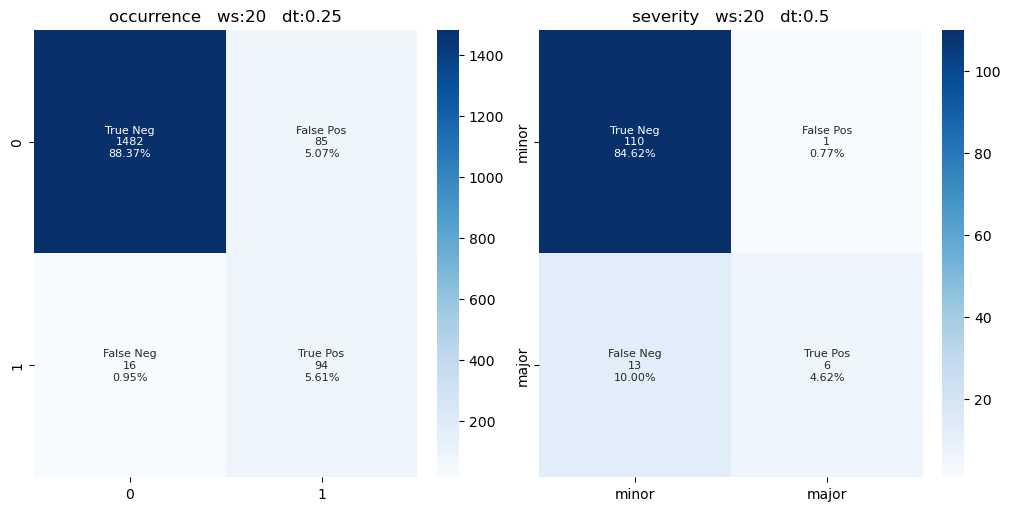

In [103]:
dt_arr=[0.25,0.5]
occurrence_predictions = occurrence_model.predict_proba(X_test)[:, 1]
severity_predictions = severity_model.predict_proba(X_test_fire_only)[:, 1]

binary_occurrence_predictions = (occurrence_predictions >= dt_arr[0]).astype(int)

test_binary_severity_predictions = np.where(severity_predictions < dt_arr[1], 'major', 'minor')

#test_binary_severity_predictions = severity_model.predict(X_test_fire_only)


accuracy = accuracy_score(y_test, binary_occurrence_predictions)
precision = precision_score(y_test, binary_occurrence_predictions)
recall = recall_score(y_test, binary_occurrence_predictions)
f1 = f1_score(y_test, binary_occurrence_predictions)
auc_roc = roc_auc_score(y_test, binary_occurrence_predictions)
print(f"Occurrence Metrics: --------------------")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision} | Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

saccuracy = accuracy_score(y_test_fire_only, test_binary_severity_predictions)
sprecision = precision_score(y_test_fire_only, test_binary_severity_predictions, pos_label='major')
srecall = recall_score(y_test_fire_only, test_binary_severity_predictions, pos_label='major')
sf1 = f1_score(y_test_fire_only, test_binary_severity_predictions, pos_label='major')
sauc_roc = roc_auc_score(y_test_fire_only, severity_predictions)
print(f"Severity Metrics: --------------------")
print(f"Accuracy: {saccuracy}")
print(f"Precision: {sprecision} | Recall: {srecall}")
print(f"F1 Score: {sf1}")
print(f"AUC-ROC: {sauc_roc}")

fig, ax = plt.subplots(1,2, constrained_layout = True, figsize=(10,5))

cf_matrix = confusion_matrix(y_test, binary_occurrence_predictions)
group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
#sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
title = 'occurrence   ws:'+str(window_size)+"   dt:"+str(dt_arr[0])
sns.heatmap(cf_matrix, annot=labels, annot_kws={"fontsize":8}, fmt='', cmap='Blues', ax=ax[0]).set(title=title)

scf_matrix = confusion_matrix(y_test_fire_only, test_binary_severity_predictions, labels = ['minor','major'])
class_labels = ['minor', 'major']
sgroup_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
sgroup_counts = ['{0:0.0f}'.format(value) for value in scf_matrix.flatten()]
sgroup_percentages = ['{0:.2%}'.format(value) for value in scf_matrix.flatten()/np.sum(scf_matrix)]
slabels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(sgroup_names,sgroup_counts,sgroup_percentages)]
slabels = np.asarray(slabels).reshape(2,2)
#sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
stitle = 'severity   ws:'+str(window_size)+"   dt:"+str(dt_arr[1])
sns.heatmap(scf_matrix, annot=slabels, annot_kws={"fontsize":8}, fmt='', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', ax=ax[1]).set(title=stitle)


1677
1677
Occurrence Metrics: --------------------
Accuracy: 0.9385807990459153


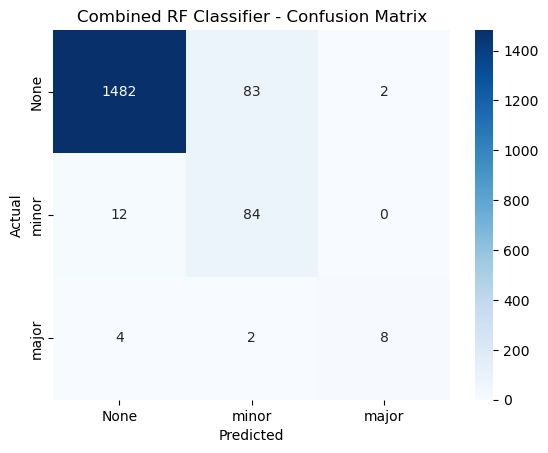

In [118]:

combined_dt_arr=[0.25,0.5]
combined_occurrence_predictions = occurrence_model.predict_proba(X_test)[:, 1]
combined_severity_predictions = severity_model.predict_proba(X_test)[:,1]

combined_binary_occurrence_predictions = (combined_occurrence_predictions >= combined_dt_arr[0]).astype(int)

combined_binary_severity_predictions = np.where(combined_severity_predictions < (1-combined_dt_arr[1]), 'major', 'minor')

print(len(combined_binary_occurrence_predictions))
print(len(combined_binary_severity_predictions))

combined_predictions = []
for ind, val in enumerate(combined_binary_occurrence_predictions):
    if val==0:
        combined_predictions.append('None')
    else:
        combined_predictions.append(combined_binary_severity_predictions[ind])
        

print(f"Occurrence Metrics: --------------------")
print(f"Accuracy: {accuracy_score(y_test_combined, combined_predictions)}")

cm = confusion_matrix(y_test_combined, combined_predictions, labels=['None', 'minor', 'major'])

# Define the class labels
class_labels = ['None', 'minor', 'major']

# Create the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Combined RF Classifier - Confusion Matrix')

# Show the plot
plt.show()